In [1]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from pprint import pprint
from tqdm import tqdm

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

2025-10-10 10:32:36.686108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 10:32:36.739301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 10:32:39.064279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of available GPUs:  2


I0000 00:00:1760110361.308525 3952857 gpu_device.cc:2411] Ignoring visible gpu device (device: 2, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.


In [2]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=0)
    return os.path.basename(f).split('.')[0][:-2], fits_data


def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Load the saved model

In [3]:
models = sorted(glob(os.path.join(config['data_dir'], 'models', '*.keras')))
pprint(models)

['/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/bryce_v1_ap99966643.keras']


In [4]:
model = keras.models.load_model(models[0])

I0000 00:00:1760110361.643859 3952857 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46551 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1760110361.645215 3952857 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46551 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Take a quick look as the format that the submission CSV needs to have

In [5]:
example_csv = '/grad/bwedig/lsst-strong-lens-data-challenge/submission_format.csv'
example_df = pd.read_csv(example_csv)
print(example_df.head())

            id  preds   ra  dec  zlens  mag_lens_g  mag_lens_r  mag_lens_i  \
0  7.53391E+16      1 -999 -999   -999        -999        -999        -999   
1  7.46439E+16      0 -999 -999   -999        -999        -999        -999   
2  4.42233E+16      1 -999 -999   -999        -999        -999        -999   
3  6.95818E+16      0 -999 -999   -999        -999        -999        -999   
4  6.95997E+16      1 -999 -999   -999        -999        -999        -999   

   mag_lens_z  mag_lens_y  ...  n_l_sers  vel_disp   RA  Dec  mag_object_g  \
0        -999        -999  ...      -999      -999 -999 -999          -999   
1        -999        -999  ...      -999      -999 -999 -999          -999   
2        -999        -999  ...      -999      -999 -999 -999          -999   
3        -999        -999  ...      -999      -999 -999 -999          -999   
4        -999        -999  ...      -999      -999 -999 -999          -999   

   mag_object_r  mag_object_i  mag_object_z  mag_object_y  z_c

Create an empty version of this

In [6]:
df = example_df.iloc[0:0].copy()
print(df)

Empty DataFrame
Columns: [id, preds, ra, dec, zlens, mag_lens_g, mag_lens_r, mag_lens_i, mag_lens_z, mag_lens_y, ell_l, ell_l_PA, Rein, vel disp, sh, sh_PA, srcx, srcy, mag_src_g, mag_src_r, mag_src_i, mag_src_z, mag_src_y, zsrc, ell_s, ell_s_PA, Reff_s, n_s_sers, ell_m, ell_m_PA, Reff_l, n_l_sers, vel_disp, RA, Dec, mag_object_g, mag_object_r, mag_object_i, mag_object_z, mag_object_y, z_central]
Index: []

[0 rows x 41 columns]


Load the `.fits` files, making sure to stack them correctly

In [13]:
data_dir = '/data/bwedig/lsst-strong-lens-data-challenge/test_dataset_updated'

fits_files = sorted(glob(os.path.join(data_dir, '*.fits')))
print(f"Found {len(fits_files)} FITS files.")

unique_ids = set([os.path.basename(f).split('.')[0][:-2] for f in fits_files])
print(f"Found {len(unique_ids)} unique IDs.")

Found 500000 FITS files.
Found 100000 unique IDs.


  0%|          | 0/100000 [00:00<?, ?it/s]

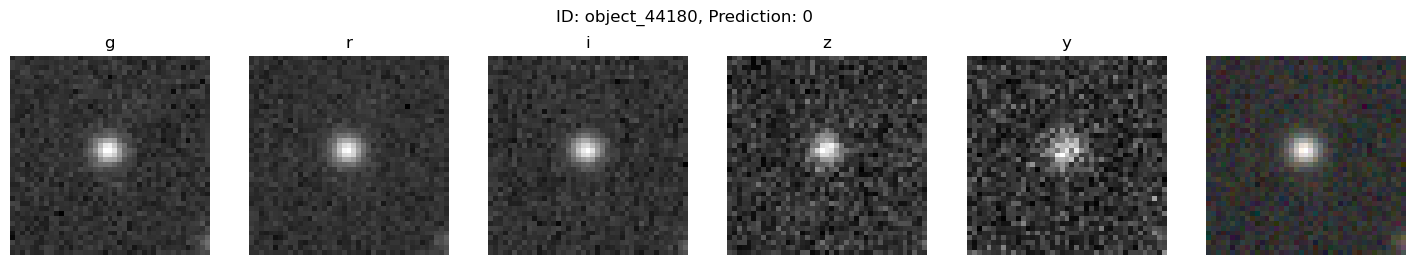

  2%|▏         | 2448/100000 [05:56<3:44:59,  7.23it/s] /tmp/ipykernel_3952857/660805427.py:19: RuntimeWarning: divide by zero encountered in power
  gamma_corrected_image = np.power(image, gamma)
  5%|▌         | 5000/100000 [12:15<3:47:04,  6.97it/s] 

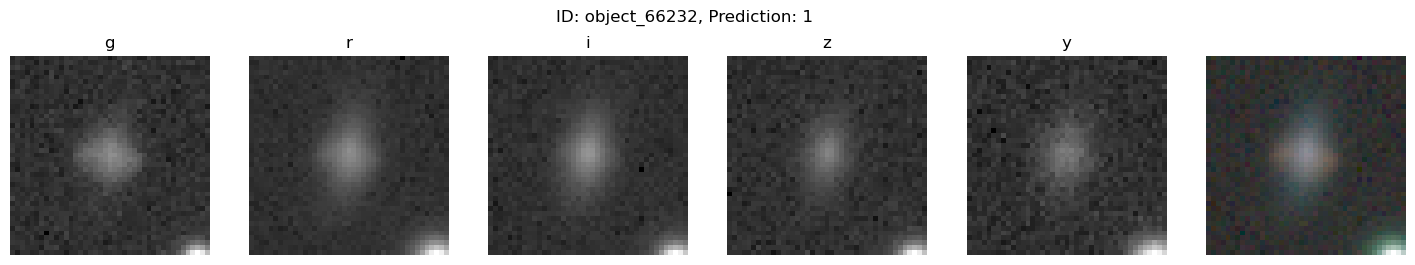

 10%|█         | 10000/100000 [24:44<3:45:32,  6.65it/s]

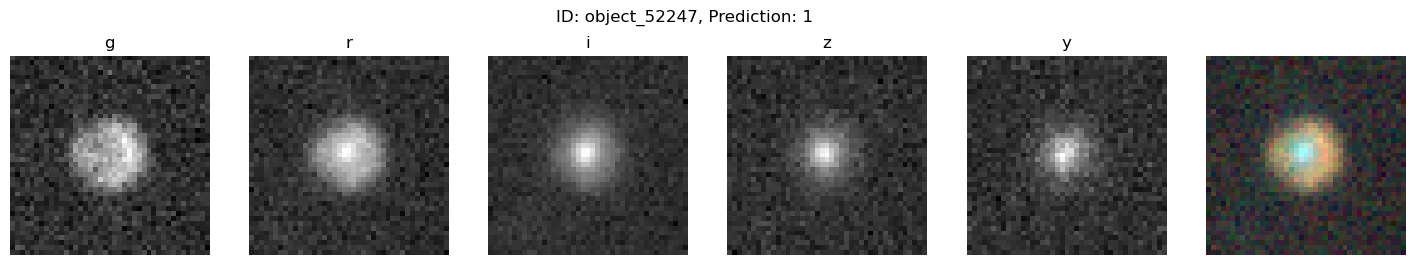

 15%|█▌        | 15000/100000 [37:16<3:20:22,  7.07it/s] 

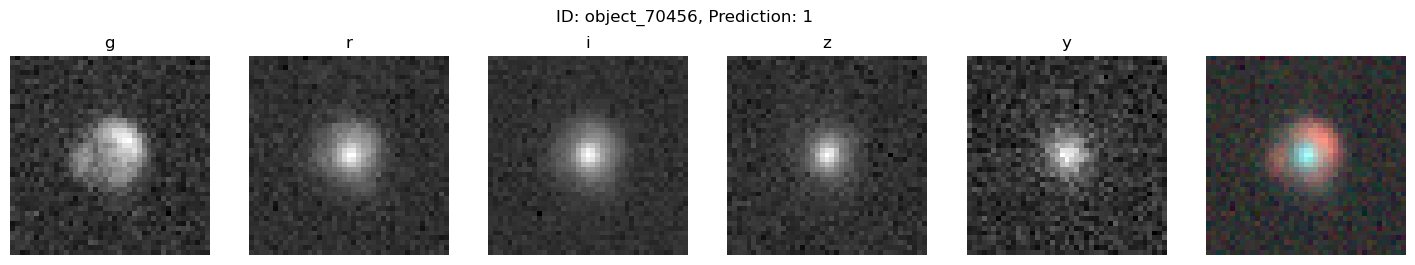

 20%|██        | 20000/100000 [49:59<3:21:05,  6.63it/s] 

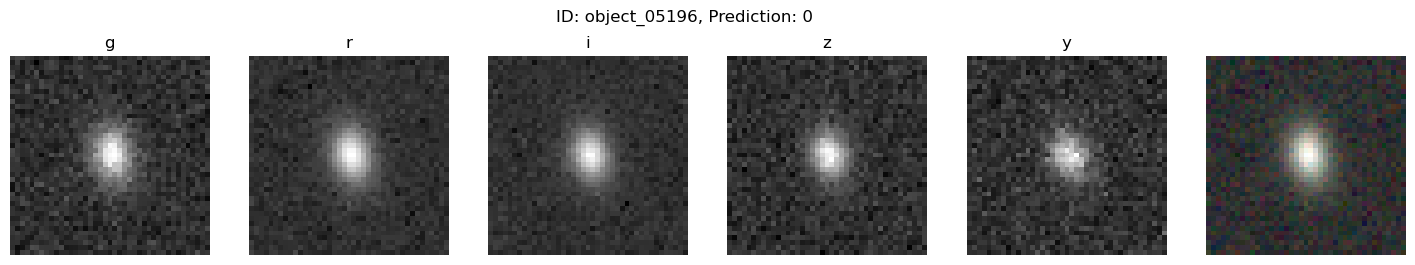

 25%|██▌       | 25000/100000 [1:02:49<3:07:17,  6.67it/s]

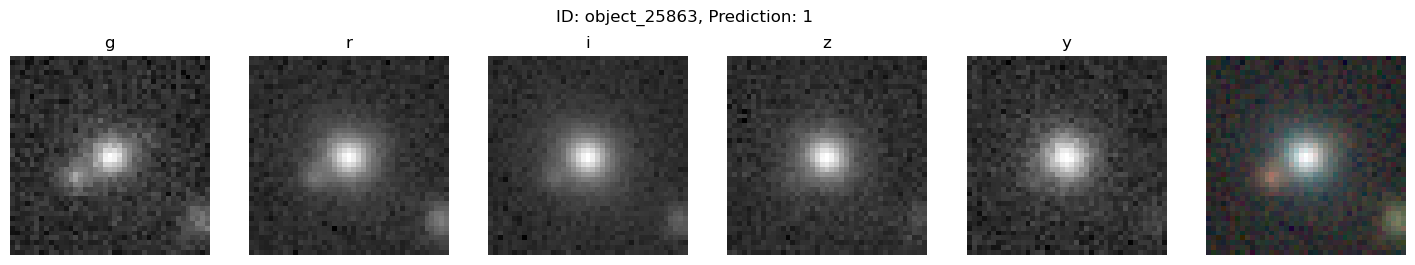

 30%|███       | 30000/100000 [1:15:32<2:54:45,  6.68it/s] 

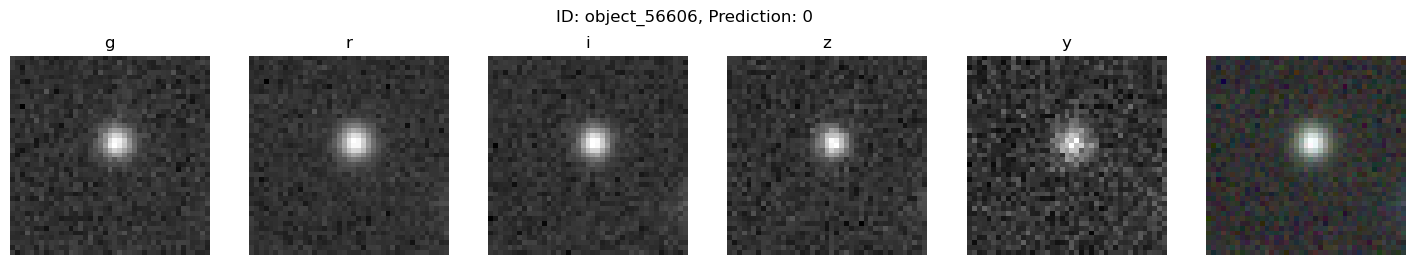

 35%|███▌      | 35000/100000 [1:28:15<2:34:41,  7.00it/s]

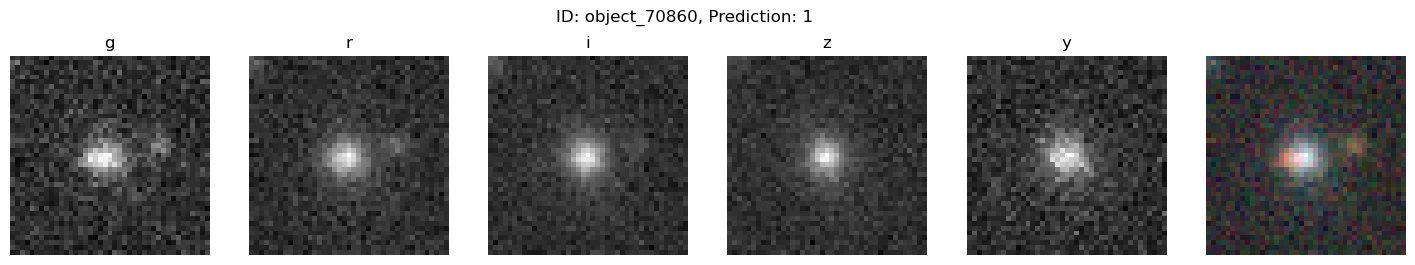

 40%|████      | 40000/100000 [1:40:56<2:35:57,  6.41it/s]

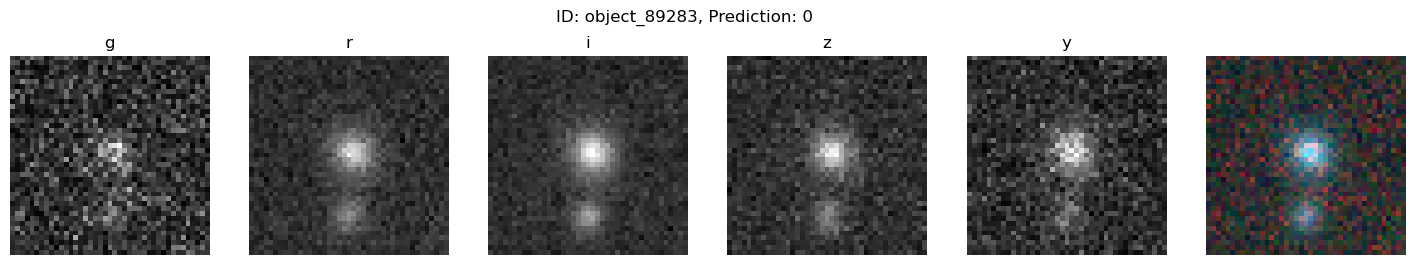

 45%|████▌     | 45000/100000 [1:53:38<2:17:27,  6.67it/s]

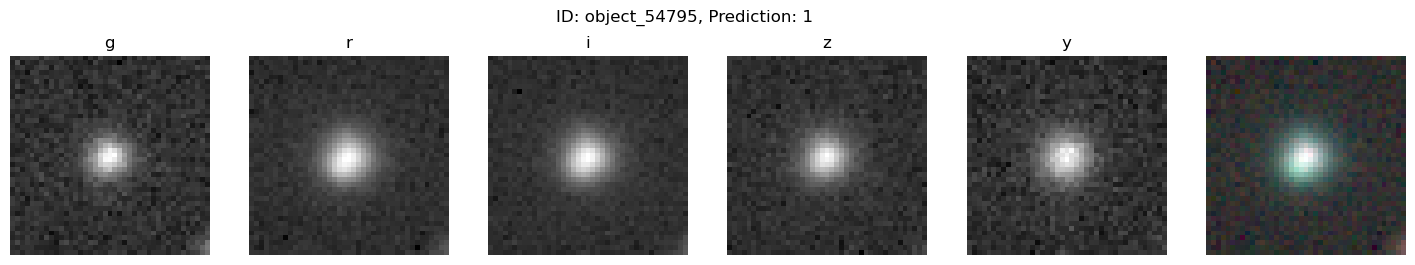

 50%|█████     | 50000/100000 [2:06:28<2:03:18,  6.76it/s]

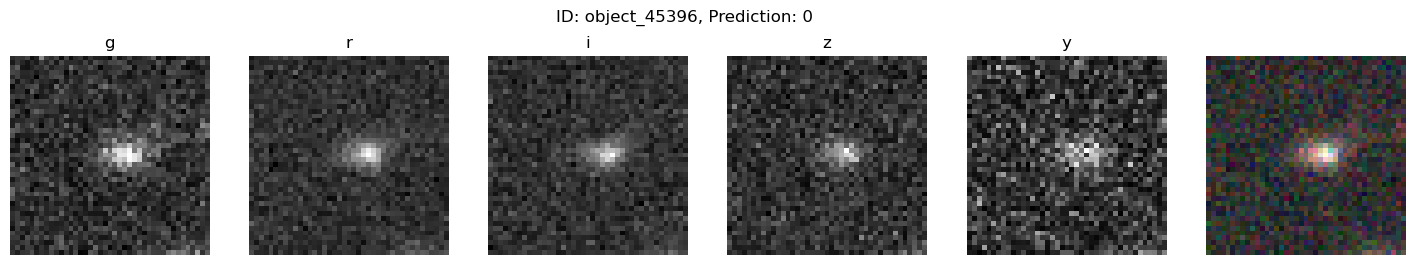

 55%|█████▌    | 55000/100000 [2:19:15<1:51:23,  6.73it/s]

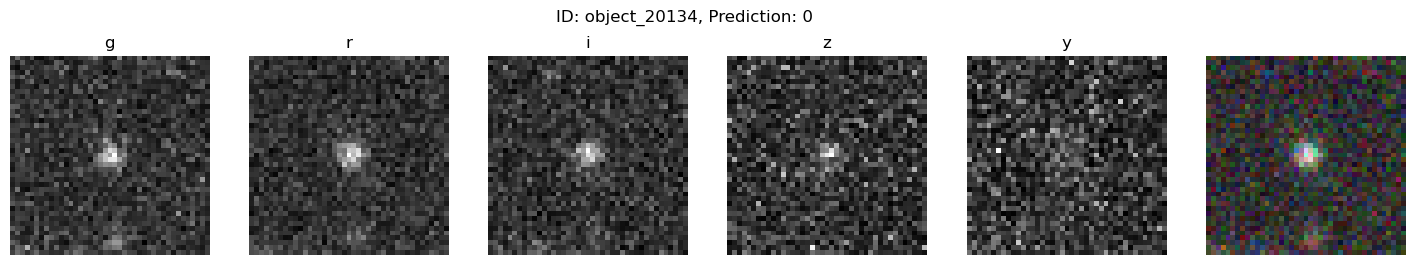

 60%|██████    | 60000/100000 [2:32:03<1:51:02,  6.00it/s]

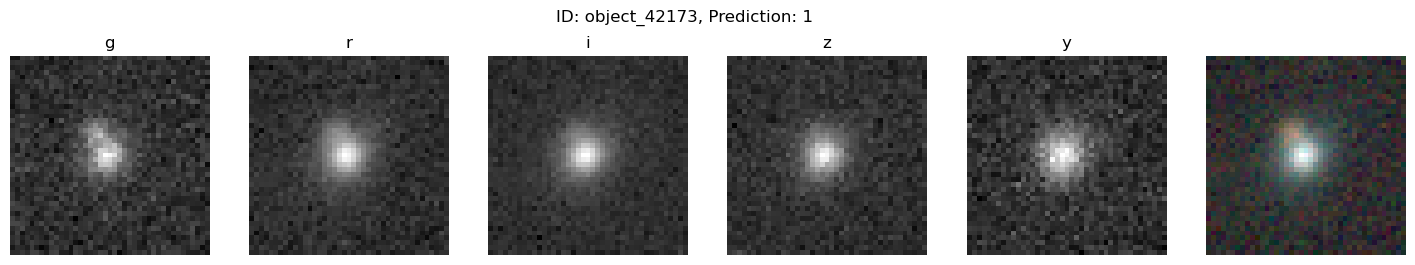

 65%|██████▌   | 65000/100000 [2:45:02<1:28:55,  6.56it/s]

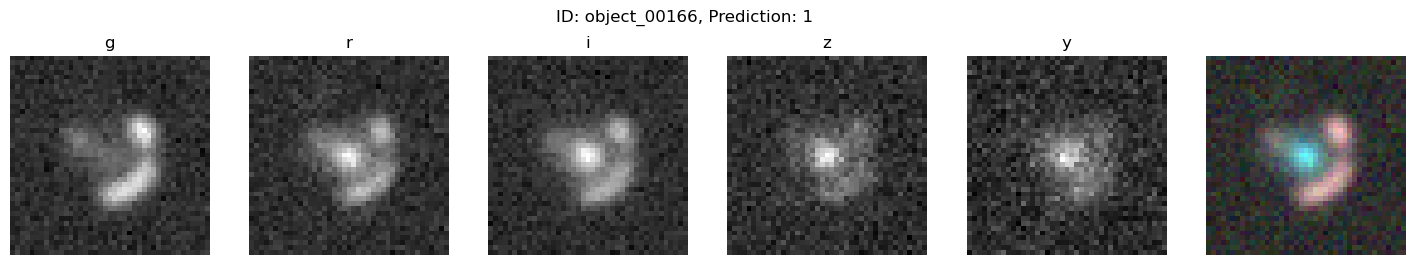

 70%|███████   | 70000/100000 [2:58:06<1:21:43,  6.12it/s]

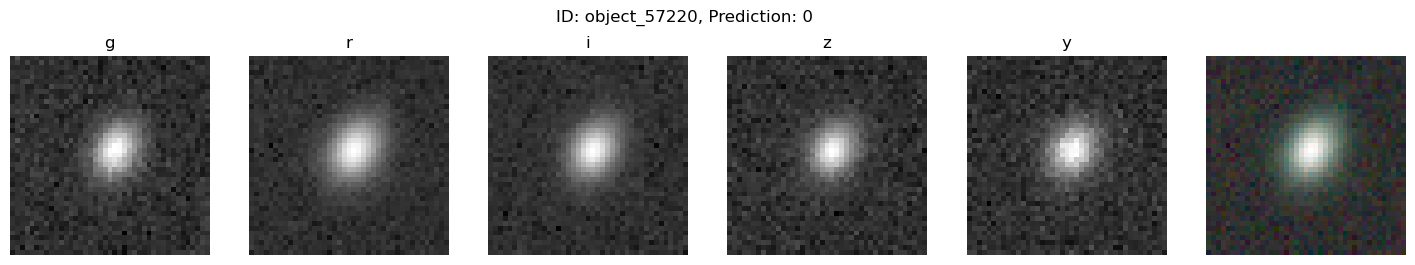

 75%|███████▌  | 75000/100000 [3:11:06<1:04:23,  6.47it/s]

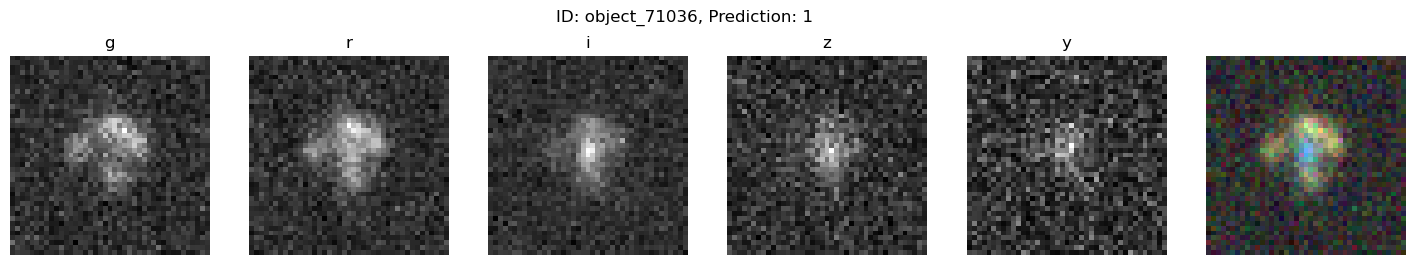

 80%|████████  | 80000/100000 [3:24:22<46:44,  7.13it/s]  

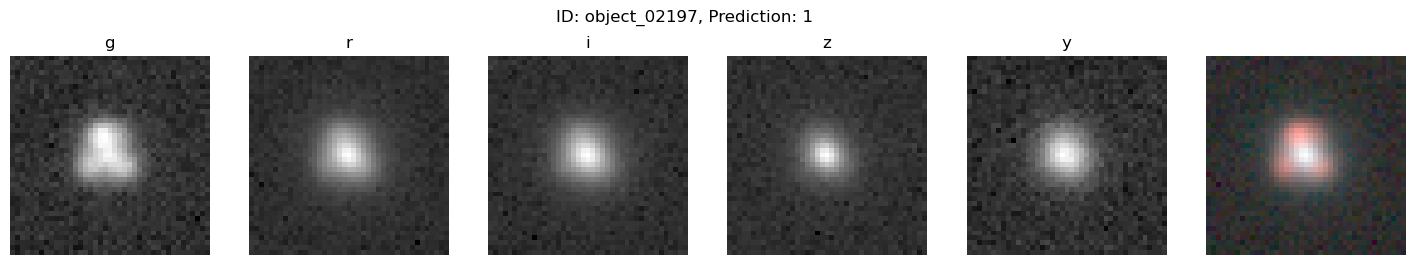

 85%|████████▌ | 85000/100000 [3:37:31<38:56,  6.42it/s]  

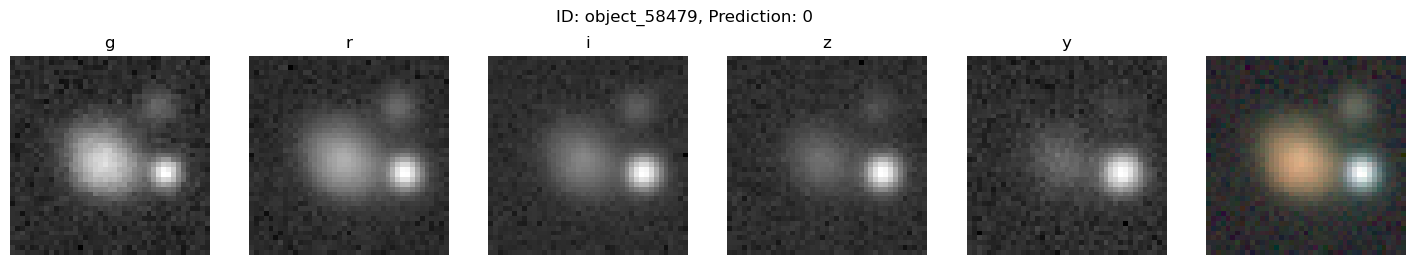

 90%|█████████ | 90000/100000 [3:50:50<24:16,  6.87it/s]  

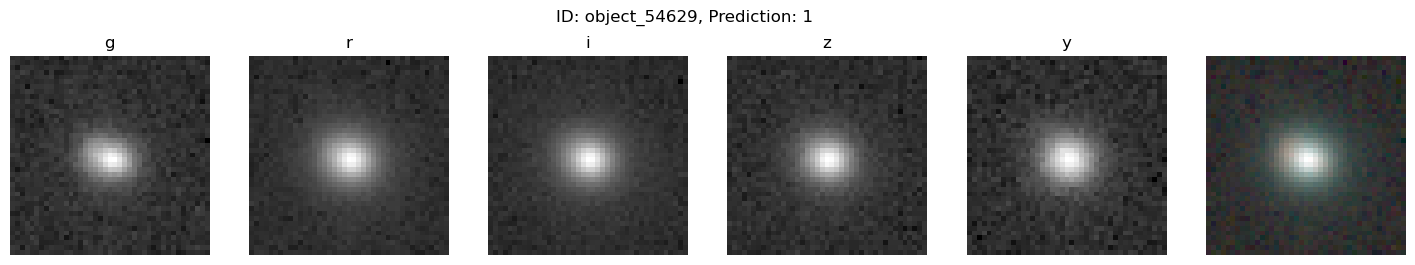

 95%|█████████▌| 95000/100000 [4:04:10<13:17,  6.27it/s]  

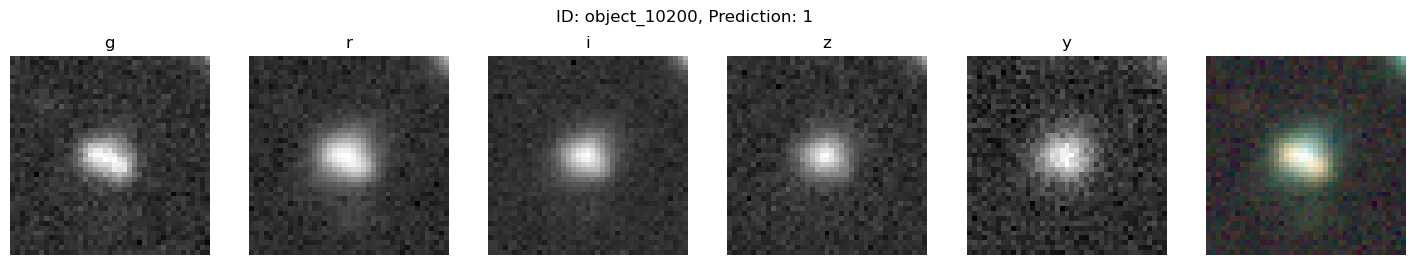

100%|██████████| 100000/100000 [4:17:22<00:00,  6.48it/s]


In [ ]:
bands = ['g', 'r', 'i', 'z', 'y']

for i, unique_str in tqdm(enumerate(unique_ids), total=len(unique_ids)):
    images = []
    for band in bands:
        file_path = os.path.join(data_dir, f'{unique_str}_{band}.fits')
        id, image = get_image_data(file_path)
        images.append(process_image(image))
    image_stack = np.stack(images, axis=-1)

    # make prediction
    input_stack = np.expand_dims(image_stack, axis=0)  # add batch dimension for prediction
    preds = model.predict(input_stack, verbose=0)
    prediction = int(keras.ops.sigmoid(preds).numpy().flatten()[0] > 0.5)
    # print(f"ID: {id}, Prediction: {prediction}")

    # append to dataframe
    new_row = {'id': id, 'preds': prediction}
    df = pd.concat([df, pd.DataFrame([new_row], columns=df.columns)], ignore_index=True)

    # plot subset as sanity check
    if i % 5000 == 0:
        f, ax = plt.subplots(1, 6, figsize=(18, 3))
        for j, band in enumerate(bands):
            ax[j].imshow(image_stack[:, :, j], cmap='gray')
            ax[j].set_title(band)
            ax[j].axis('off')
        ax[5].imshow(image_stack[:, :, :3])
        ax[5].axis('off')
        plt.suptitle(f"ID: {id}, Prediction: {prediction}")
        # plt.savefig('figures/' + id + '.png')
        plt.show()

    # if i == 5:
    #     break

In [22]:
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,object_44180,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,object_54510,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,object_34614,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,object_66715,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,object_23448,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100099,object_21771,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100100,object_39986,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100101,object_52924,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100102,object_79521,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df = df.fillna(-999)
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,object_44180,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,object_54510,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,object_34614,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,object_66715,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,object_23448,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100099,object_21771,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
100100,object_39986,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
100101,object_52924,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
100102,object_79521,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [ ]:
out_path = '/data/bwedig/lsst-strong-lens-data-challenge/bryce_submission.csv'
if os.path.exists(out_path):
    os.remove(out_path)
df.to_csv(out_path, index=False)
print(f"Wrote {out_path}")